In [155]:
import pandas as pd
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import MinMaxScaler
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

**Aim: To cluster locations/tourist destinations based on tourist experience and COVID situation (cases).**

# Preparing the data for clustering

## Data import

In [156]:
df = pd.read_csv("data/untitled.txt")
df = df.drop(columns='Unnamed: 0')

In [157]:
df

,iso_code,location,continent,date,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
0,ALB,Albania,Europe,2020-02-25,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
1,ALB,Albania,Europe,2020-02-26,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
2,ALB,Albania,Europe,2020-02-27,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
3,ALB,Albania,Europe,2020-02-28,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
4,ALB,Albania,Europe,2020-02-29,NaN,NaN,8.33,NaN,0.795,35.50,4.01,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
88602,ZWE,Zimbabwe,Africa,2022-03-22,0.000,16.811,NaN,0.0841,0.571,45.68,2.95,NaN
88603,ZWE,Zimbabwe,Africa,2022-03-23,18.089,12.381,NaN,0.0648,0.571,45.68,2.95,NaN
88604,ZWE,Zimbabwe,Africa,2022-03-24,15.637,14.615,NaN,0.0802,0.571,45.68,2.95,NaN
88605,ZWE,Zimbabwe,Africa,2022-03-25,29.883,15.457,NaN,NaN,0.571,45.68,2.95,NaN


## Computing medians of quantitative columns

In [158]:
medians = df.groupby(["iso_code"]).median()

In [159]:
medians

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,,,
ALB,58.3030,86.7700,56.48,0.1670,0.795,35.50,4.01,2.0
ARE,98.4380,98.9455,54.63,0.0076,0.890,58.33,5.63,2.0
ARG,153.4455,151.1790,77.31,0.1830,0.845,34.69,4.53,3.0
ARM,109.6650,119.0265,NaN,0.1185,0.776,33.89,4.33,NaN
AUS,1.2800,1.0750,65.28,0.0009,0.944,77.75,6.06,4.0
...,...,...,...,...,...,...,...,...
VNM,0.1220,0.1130,67.13,0.0719,0.704,37.48,2.85,4.0
YEM,0.1970,0.2340,27.78,NaN,0.470,53.14,1.87,3.0
ZAF,38.9060,41.2240,50.93,0.0939,0.709,42.09,4.30,1.0


In [160]:
medians = medians.fillna(df.median())

/tmp/ipykernel_7501/4062631757.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  medians = medians.fillna(df.median())


In [161]:
medians

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,,,
ALB,58.3030,86.7700,56.48,0.1670,0.795,35.50,4.01,2.0
ARE,98.4380,98.9455,54.63,0.0076,0.890,58.33,5.63,2.0
ARG,153.4455,151.1790,77.31,0.1830,0.845,34.69,4.53,3.0
ARM,109.6650,119.0265,57.41,0.1185,0.776,33.89,4.33,3.0
AUS,1.2800,1.0750,65.28,0.0009,0.944,77.75,6.06,4.0
...,...,...,...,...,...,...,...,...
VNM,0.1220,0.1130,67.13,0.0719,0.704,37.48,2.85,4.0
YEM,0.1970,0.2340,27.78,0.0590,0.470,53.14,1.87,3.0
ZAF,38.9060,41.2240,50.93,0.0939,0.709,42.09,4.30,1.0


## Correlation analysis

In [162]:
corr = medians.corr()
corr.style.background_gradient(cmap='coolwarm')

,new_cases_per_million,new_cases_smoothed_per_million,stringency_index,positive_rate,human_development_index,cost_living_index,tourist_service_index,international_travel_controls
new_cases_per_million,1.000000,0.914938,0.053519,0.070644,0.500498,0.120721,0.455251,-0.030952
new_cases_smoothed_per_million,0.914938,1.000000,0.046726,0.086815,0.512850,0.183527,0.498469,-0.038522
stringency_index,0.053519,0.046726,1.000000,0.092060,0.056014,-0.150721,-0.000776,0.278064
positive_rate,0.070644,0.086815,0.092060,1.000000,-0.107649,-0.322670,-0.119444,-0.280216
human_development_index,0.500498,0.512850,0.056014,-0.107649,1.000000,0.634269,0.825188,0.347224
cost_living_index,0.120721,0.183527,-0.150721,-0.322670,0.634269,1.000000,0.602240,0.279560
tourist_service_index,0.455251,0.498469,-0.000776,-0.119444,0.825188,0.602240,1.000000,0.246671
international_travel_controls,-0.030952,-0.038522,0.278064,-0.280216,0.347224,0.279560,0.246671,1.000000


Correlated columns:

- new_cases_per_million and new_cases_smoothed_per_million (keep new_cases_smoothed_per_million)
- human_development_index and tourist_service_index (keep tourist_service_index)

In [163]:
medians = medians.drop(columns = ["new_cases_per_million", "human_development_index"])

In [164]:
medians

,new_cases_smoothed_per_million,stringency_index,positive_rate,cost_living_index,tourist_service_index,international_travel_controls
iso_code,,,,,,
ALB,86.7700,56.48,0.1670,35.50,4.01,2.0
ARE,98.9455,54.63,0.0076,58.33,5.63,2.0
ARG,151.1790,77.31,0.1830,34.69,4.53,3.0
ARM,119.0265,57.41,0.1185,33.89,4.33,3.0
AUS,1.0750,65.28,0.0009,77.75,6.06,4.0
...,...,...,...,...,...,...
VNM,0.1130,67.13,0.0719,37.48,2.85,4.0
YEM,0.2340,27.78,0.0590,53.14,1.87,3.0
ZAF,41.2240,50.93,0.0939,42.09,4.30,1.0


## Dropping unnecessary columns

In [165]:
# not a true quantitative column
medians = medians.drop(columns = ["international_travel_controls"])

We attempt to perform clustering using just two variables - `new_cases_smoothed_per_million` and `tourist_service_index`. The former represents the country's COVID situation; the latter represents the typical experience of a tourist visiting the country.

In [166]:
medians = medians.drop(columns = ["positive_rate", "cost_living_index", "stringency_index"])

In [167]:
medians

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,86.7700,4.01
ARE,98.9455,5.63
ARG,151.1790,4.53
ARM,119.0265,4.33
AUS,1.0750,6.06
...,...,...
VNM,0.1130,2.85
YEM,0.2340,1.87
ZAF,41.2240,4.30


## Min-max scaling

In [168]:
iso_code = medians.index

In [169]:
scaler = MinMaxScaler()

In [170]:
medians_scaled = scaler.fit_transform(medians)

In [171]:
medians_scaled = pd.DataFrame(medians_scaled, columns = ["new_cases_smoothed_per_million", "tourist_service_index"], index = iso_code)
medians_scaled

,new_cases_smoothed_per_million,tourist_service_index
iso_code,,
ALB,0.227473,0.458753
ARE,0.259392,0.784708
ARG,0.396325,0.563380
ARM,0.312035,0.523139
AUS,0.002818,0.871227
...,...,...
VNM,0.000296,0.225352
YEM,0.000613,0.028169
ZAF,0.108071,0.517103


# Hierarchical clustering

## Dendogram

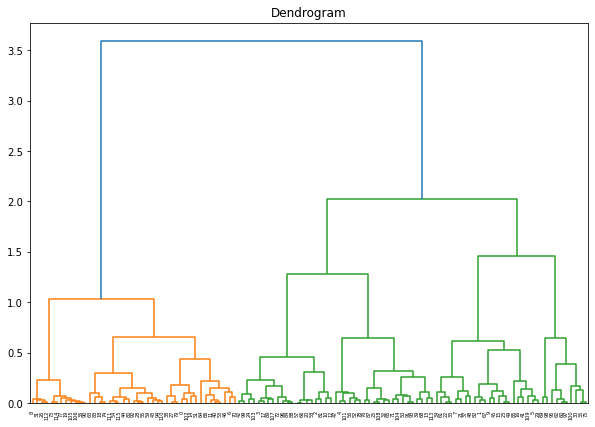

In [172]:
plt.figure(figsize=(10, 7))  
plt.title("Dendrogram") 
dend = shc.dendrogram(shc.linkage(medians_scaled, method='ward'))
plt.show()

By looking at the dendogram, values that might work well for number of hierarchical clusters are

- 2
- 3
- 5
- 6

## Choosing number of hierarchical clusters (silhoutte analysis)

> Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

[scikit-learn docs](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html)

In [173]:
def hcluster_compute_silhouette_score(scaled_data, n):
    cluster = AgglomerativeClustering(n_clusters=n, affinity='euclidean', linkage='ward')
    cluster_labels = cluster.fit_predict(scaled_data)
    silhouette_avg = silhouette_score(scaled_data, cluster_labels)
    return silhouette_avg

In [174]:
n_clusters_vals = [2, 3, 5, 6]
silhoutte_scores = {}

for n in n_clusters_vals:
    silhoutte_scores[n] = hcluster_compute_silhouette_score(medians_scaled, n)

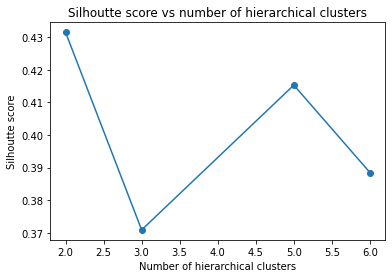

In [175]:
plt.scatter(silhoutte_scores.keys(), silhoutte_scores.values())
plt.plot(silhoutte_scores.keys(), silhoutte_scores.values())
plt.title("Silhoutte score vs number of hierarchical clusters")
plt.xlabel("Number of hierarchical clusters")
plt.ylabel("Silhoutte score")
plt.show()

Using 2 clusters gives highest silhoutte score; however, this isn't really granular enough for our purposes.

Thus, we select 5 as our number of clusters (second-highest silhoutte score, after 2 clusters).

## Hierarchical clustering

In [176]:
nclusters = 5

In [177]:
cluster = AgglomerativeClustering(n_clusters=nclusters, affinity='euclidean', linkage='ward')  

In [178]:
cluster.fit_predict(medians_scaled)

array([0, 3, 4, 4, 1, 3, 0, 3, 0, 3, 4, 0, 4, 1, 0, 3, 3, 4, 0, 0, 4, 3,
       3, 3, 4, 1, 0, 0, 0, 3, 2, 0, 1, 3, 3, 2, 0, 3, 0, 1, 0, 3, 4, 0,
       0, 3, 0, 1, 3, 3, 1, 0, 1, 0, 0, 0, 1, 4, 4, 0, 2, 3, 2, 0, 0, 1,
       4, 3, 1, 2, 0, 1, 4, 0, 0, 2, 1, 0, 1, 0, 0, 4, 3, 0, 4, 3, 0, 1,
       4, 4, 0, 1, 0, 1, 0, 2, 4, 2, 2, 4, 2, 1, 0, 4, 1, 0, 0, 4, 1, 3,
       0, 0, 0, 1, 0, 0])

In [179]:
medians_with_clusters = medians.copy(deep = True)
medians_with_clusters["hcluster"] = cluster.fit_predict(medians_scaled)

In [180]:
iso_location = df[["iso_code", "location"]].drop_duplicates()

In [181]:
medians_with_clusters

,new_cases_smoothed_per_million,tourist_service_index,hcluster
iso_code,,,
ALB,86.7700,4.01,0
ARE,98.9455,5.63,3
ARG,151.1790,4.53,4
ARM,119.0265,4.33,4
AUS,1.0750,6.06,1
...,...,...,...
VNM,0.1130,2.85,0
YEM,0.2340,1.87,0
ZAF,41.2240,4.30,1


In [182]:
medians_with_location = pd.merge(medians_with_clusters, iso_location, on="iso_code")

In [183]:
for i in range(nclusters):
    print(f"Cluster {i}:")
    print(list(medians_with_location[medians_with_location["hcluster"] == i]["location"]))
    print()

Cluster 0:
['Albania', 'Azerbaijan', 'Bangladesh', 'Bolivia', 'Botswana', 'China', 'Cameroon', 'Algeria', 'Ecuador', 'Egypt', 'Ethiopia', 'Ghana', 'Guatemala', 'Honduras', 'Indonesia', 'India', 'Iran', 'Jordan', 'Kazakhstan', 'Kenya', 'Cambodia', 'Sri Lanka', 'Morocco', 'Moldova', 'Mongolia', 'Nigeria', 'Nicaragua', 'Nepal', 'Oman', 'Pakistan', 'Philippines', 'Paraguay', 'Rwanda', 'Senegal', 'El Salvador', 'Tunisia', 'Tanzania', 'Uganda', 'Venezuela', 'Vietnam', 'Yemen', 'Zambia', 'Zimbabwe']

Cluster 1:
['Australia', 'Barbados', 'Dominican Republic', 'Finland', 'Hong Kong', 'Iceland', 'Jamaica', 'Japan', 'South Korea', 'Mexico', 'Myanmar', 'Mauritius', 'Norway', 'New Zealand', 'Qatar', 'Saudi Arabia', 'Singapore', 'Thailand', 'Taiwan', 'Uruguay', 'South Africa']

Cluster 2:
['Estonia', 'Georgia', 'Lithuania', 'Latvia', 'Montenegro', 'Netherlands', 'Serbia', 'Slovakia', 'Slovenia', 'Seychelles']

Cluster 3:
['United Arab Emirates', 'Austria', 'Belgium', 'Bulgaria', 'Canada', 'Switzerla

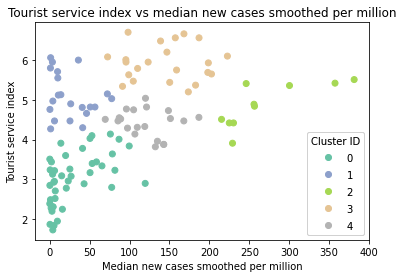

In [184]:
fig, ax = plt.subplots()

scatter = ax.scatter("new_cases_smoothed_per_million", "tourist_service_index", data = medians_with_location, c = "hcluster", cmap = "Set2")
legend = ax.legend(*scatter.legend_elements(),
                    loc="lower right", title="Cluster ID")
ax.add_artist(legend)
plt.title("Tourist service index vs median new cases smoothed per million")
plt.xlabel("Median new cases smoothed per million")
plt.ylabel("Tourist service index")
plt.show()

Cluster descriptions:

| Cluster ID | Description                                      |
|:------------:|:--------------------------------------------------|
| 0          | Average/poor tourist service, low case numbers.  |
| 1          | Good tourist service, low case numbers.          |
| 2          | Average/good tourist service, high case numbers. |
| 3          | Good tourist service, medium case numbers.       |
| 4          | Average tourist service, medium case numbers.    |